# Combine GP

**Goal:** Sean shared a sampler that:

1. Fits the (blinded) massplane
2. Draws samples from the unblinded GP prediction for the 2d histogram
3. Smear these $m_{h1}, m_{h2}$ predictions

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import combinations
from glob import glob
from time import time

import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import pearsonr

from plotUtils import significance

import os
os.sys.path += ['../GraphNN/','../Flow-Models/','../gp-for-flows/','../PyATLASstyle/'] 
from preprocess import MDpT_cut,MDR_cut

from gp import *
from bkgPred import *

from densityEstimate import *
from densityPlots import *

from plotting import SR_x, SR_y1, SR_y2

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)

import matplotlib as mpl
mpl.rcParams.update({'figure.max_open_warning': 0})

%load_ext autoreload
%autoreload 2

Welcome to JupyROOT 6.22/00
Running w/ conda env: don't import root packages.


../PyATLASstyle/PyATLASstyle.py:12: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


## Step 0: Load in the dataset

In [4]:
yr = 17

In [5]:
subDir = f'data{yr}_PFlow-FEB20-5jets'
tag = '_SM_2b_p_0.01'
seedTag = ''
prodTag = 'FEB20'
ntag = 2

cols = ['log_pT_h1','log_pT_h2','eta_h1','eta_h2','log_dphi_hh']
colTag = '_'.join(cols)
s = f'm_h1>{126-45} & m_h1<{126+45} & m_h2>{116-45} & m_h2<{116+45}'
d = data(5, yr, prodTag, tag, ntag, s)

deta_cut = (d.df.abs_deta_hh < 1.5)  
d.mlPrepare(deta_cut,cols,N=-1)

../data/data17_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 43161 events from 43161 available for the training / validation set


## Step 1: Load in the model from Sean and get the predictions

In [21]:
full_data = d.df[deta_cut]
nbinsx,nbinsy = 50,50

#Train on full box - SR will be blinded in training
bins = [np.linspace(126-45, 126+45, nbinsx+1), 
        np.linspace(116-45, 116+45, nbinsy+1)]

density = GPdensity(full_data, bins, blind=True)
density.train()

nBlind = np.sum(deta_cut) 
nPreds = 10

nEvents = nBlind * nPreds
m1,m2 =density.sample(nEvents)

../gp-for-flows/gp.py:52: RuntimeWarning: divide by zero encountered in true_divide
  stat_err = (np.maximum(bkgd_2d, np.ones(bkgd_2d.shape))/bkgd_2d).flatten()


RBF(length_scale=[64.6, 56.4])


In [5]:
n_sig = density.getNorm()

In [6]:
n_sig

18197.39822534379

In [7]:
nEvents

1122950

**Sanity checking some plots**

In [11]:
text = "$\mathbf{ATLAS}$ Data Internal\n"
text += f"20{yr} data, FEB20 MNT prod\n"
text += "DL1r 77% WP, $\mathrm{P}$ SM, $|\Delta \eta_{hh}| < 1.5$"

In [12]:
figBaseDir = f'figures/{subDir}{tag}_2b_detaCut'
figBaseDir

'figures/data17_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut'

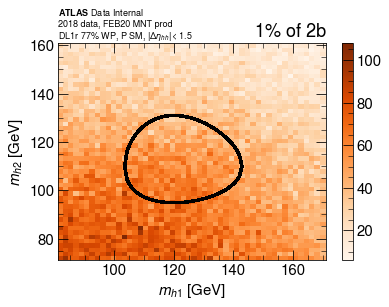

In [10]:
plt.hist2d(*full_data[['m_h1','m_h2']].values.T,bins,cmap='Oranges')
plt.colorbar()
plt.xlabel('$m_{h1}$ [GeV]')
plt.ylabel('$m_{h2}$ [GeV]')
plt.title('1% of 2b',loc='right')

ax = plt.gca()
plt.text(0,1, text, ha='left',va='bottom',transform=ax.transAxes,fontsize=9)

# overlay the SR circle
plt.plot(SR_x, SR_y1,'k')
plt.plot(SR_x, SR_y2,'k')

plt.savefig(f'{figBaseDir}/gpPlots/massplane_zoom.pdf',bbox_inches='tight')

plt.show()

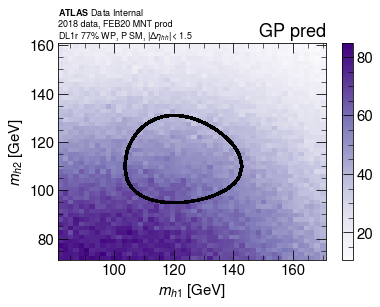

In [11]:
plt.hist2d(m1,m2,bins,cmap='Purples',weights=np.ones_like(m1)/nPreds)
plt.colorbar()
plt.xlabel('$m_{h1}$ [GeV]')
plt.ylabel('$m_{h2}$ [GeV]')
plt.title('GP pred',loc='right')

ax = plt.gca()
plt.text(0,1, text, ha='left',va='bottom',transform=ax.transAxes,fontsize=9)

# overlay the SR circle
plt.plot(SR_x, SR_y1,'k')
plt.plot(SR_x, SR_y2,'k')

plt.savefig(f'{figBaseDir}/gpPlots/massplane_pred.pdf',bbox_inches='tight')
plt.show()

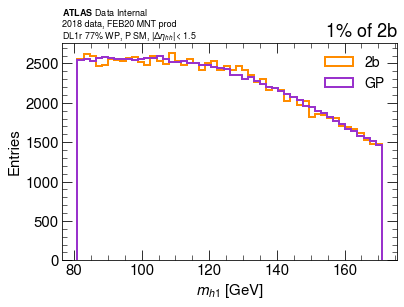

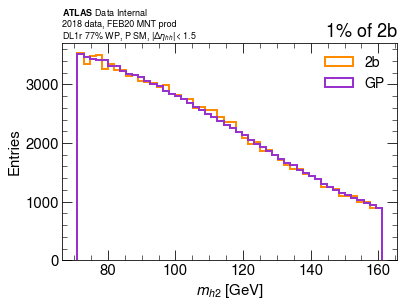

In [12]:
for c,v,xl in zip(['m_h1','m_h2'],[m1,m2],['$m_{h1}$','$m_{h2}$']):
    
    plt.figure()
    plt.hist(full_data[c],50,color='darkorange',histtype='step',label='2b',lw=2)
    plt.hist(v,50,color='darkorchid',histtype='step',label='GP',lw=2,
             weights=np.ones_like(v)/nPreds)
    
    plt.legend()
    plt.xlabel(f'{xl} [GeV]')
    plt.ylabel('Entries')
    
    plt.title('1% of 2b',loc='right')

    ax = plt.gca()
    plt.text(0,1, text, ha='left',va='bottom',transform=ax.transAxes,fontsize=9)
    
    plt.savefig(f'{figBaseDir}/gpPlots/{c}_zoom.pdf',bbox_inches='tight')

## Step 2: Overlay plots *in* the SR

Ok - so the above plots were j for my own intuition, but the rest of this logic is already in `bkgPred.py`, so I think it's fine to j go to the message plots in the SR now.

In [6]:
configs = ['val1','val2','val3','sr1','sr2']

In [7]:
hdict = {c:{} for c in configs} # GP + flow
fdict = {c:{} for c in configs} # flow only

for c in configs:
    
    fc = f'../gp-for-flows/configs/{c}.json'
    with open(fc,'r') as cfile:
            hps = json.load(cfile)
    
    L,H,nb,K,lr,beta,p = hps['L'],hps['H'],hps['nb'],hps['K'],hps['lr'],hps['beta'],hps['p']
    colTag = '_'.join(hps['cols'])
    
    modelDir = f'../gp-for-flows/models/{subDir}{tag}_2b_detaCut'
    modelConfig = f'nsf_rq-coupling_{colTag}_lu_{L}_layers_H_{H}_{nb}_blocks_K_{K}_B_3_lr_{lr}_{beta}_p{p}_iter0'
    
    # Let's also save some args that might be useful for X and Y
    hdict[c]['modelConfig'] = modelConfig
    
    with open(f'{modelDir}/{modelConfig}/hists_gp_100k.json','r') as hfile:
        out = json.load(hfile)
        
    with open(f'{modelDir}/{modelConfig}/hists_flow_10preds.json','r') as hfile:
        fout = json.load(hfile)

    for k in out.keys():
        hdict[c][k] = np.array( out[k])
        fdict[c][k] = np.array(fout[k])
        
    print(modelConfig)

nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_1_blocks_K_4_B_3_lr_0.001_1e-06_p0.1_iter0
nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_64_2_blocks_K_4_B_3_lr_0.0003_0.0001_p0.1_iter0
nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_64_2_blocks_K_4_B_3_lr_0.001_1e-05_p0.1_iter0
nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_10_layers_H_32_2_blocks_K_4_B_3_lr_0.001_0.001_p0.1_iter0
nsf_rq-coupling_log_pT_h1_log_pT_h2_eta_h1_eta_h2_log_dphi_hh_lu_5_layers_H_16_2_blocks_K_4_B_3_lr_0.0005_1e-05_p0.2_iter0


In [8]:
colors = ['blueviolet','C3','deeppink','turquoise','mediumblue']

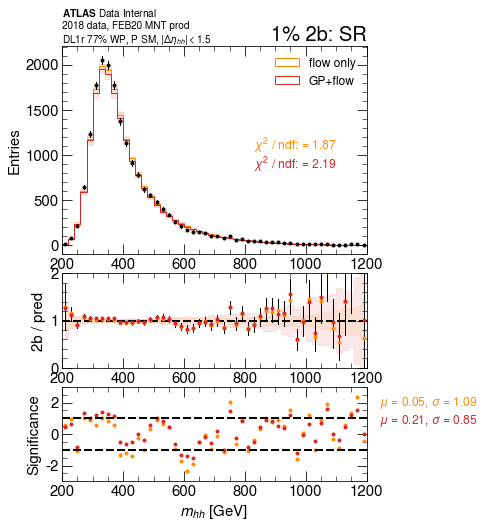

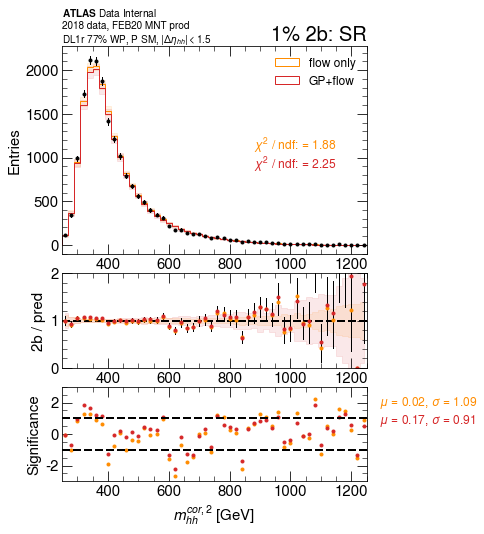

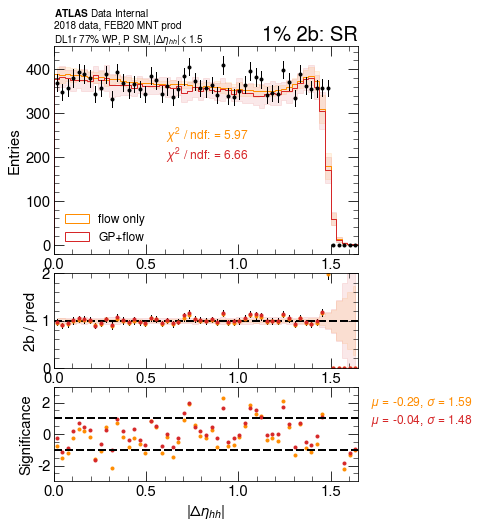

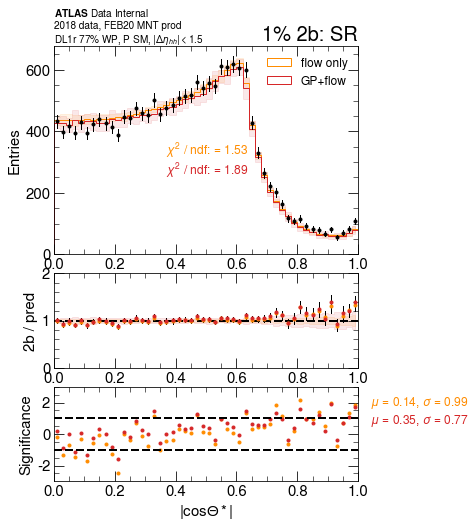

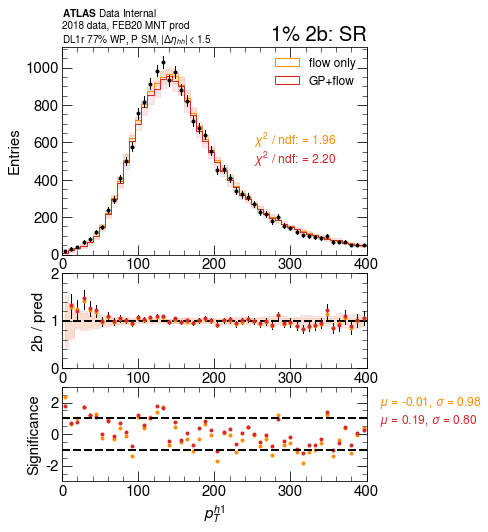

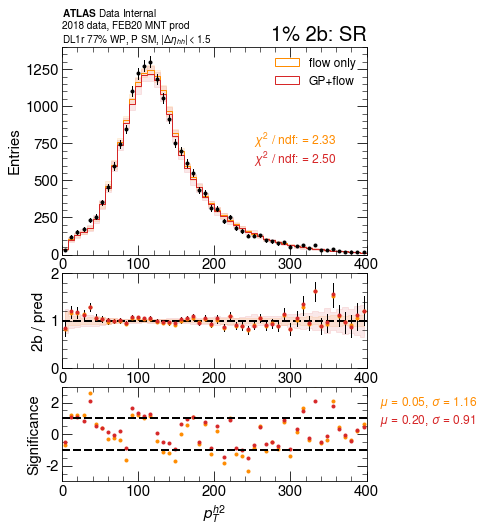

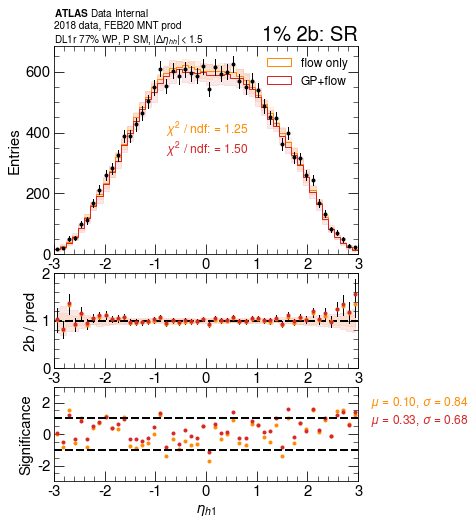

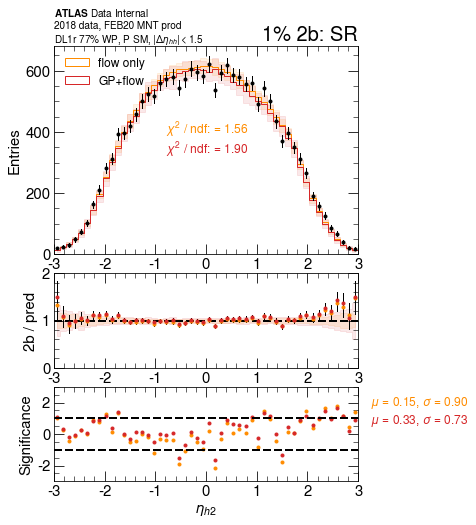

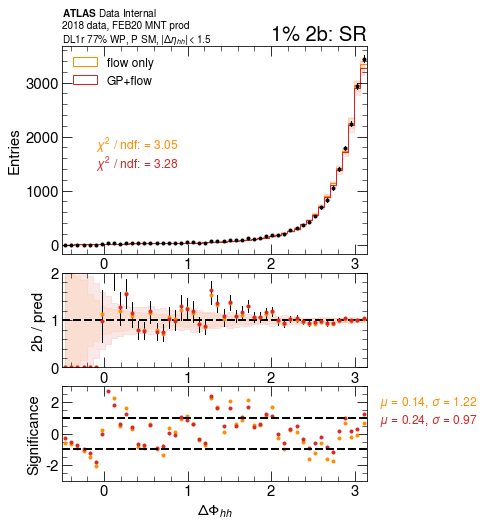

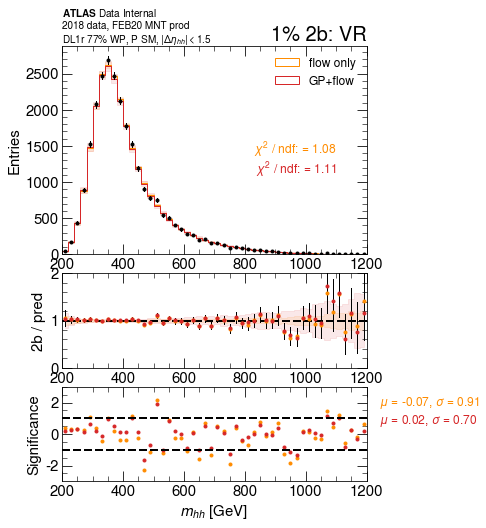

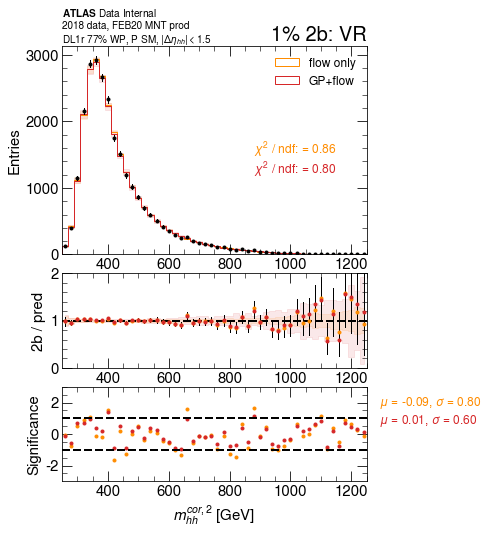

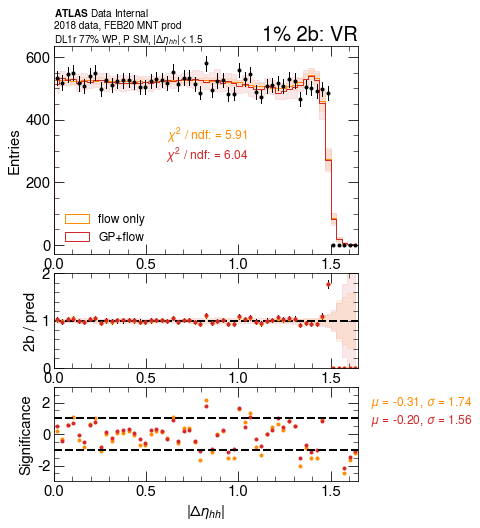

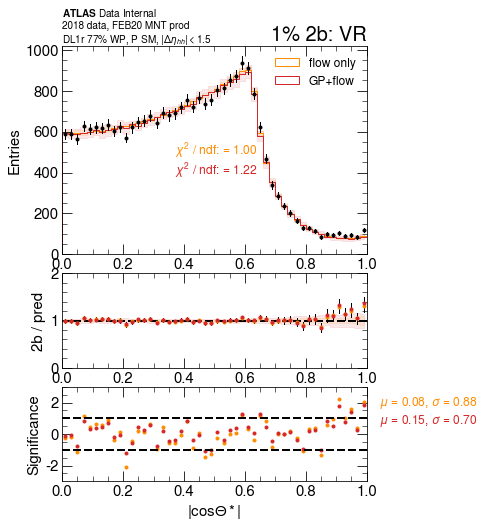

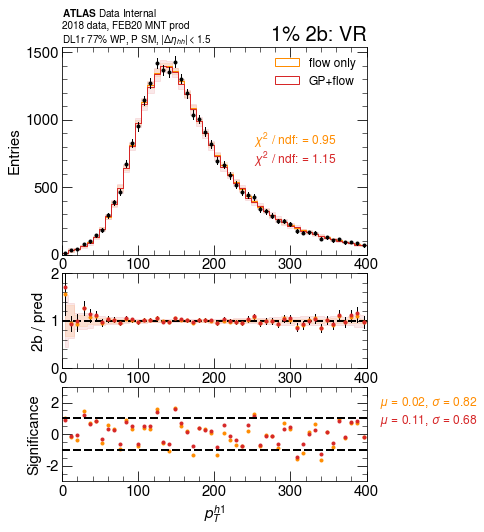

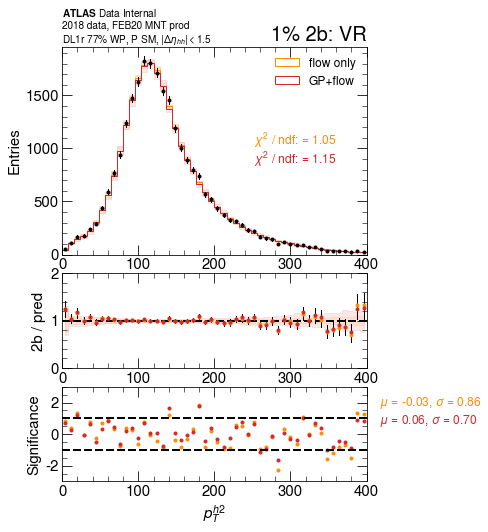

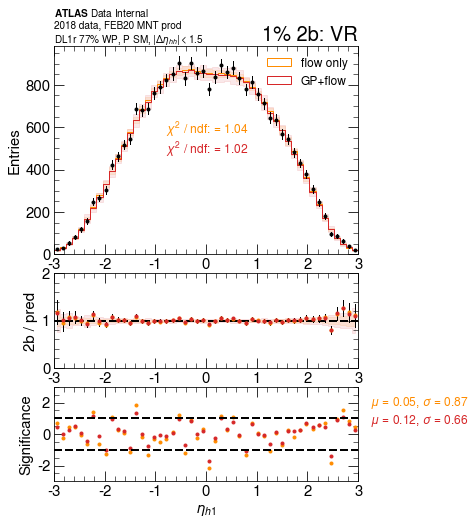

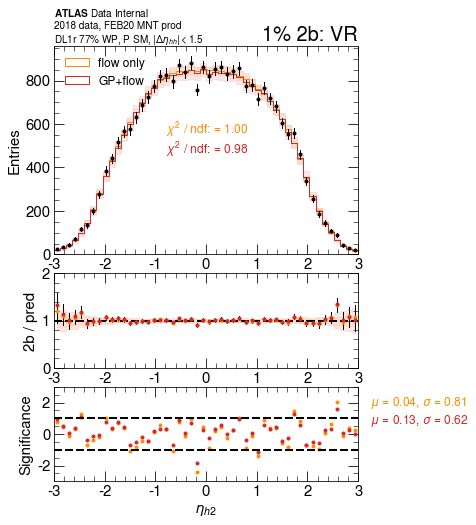

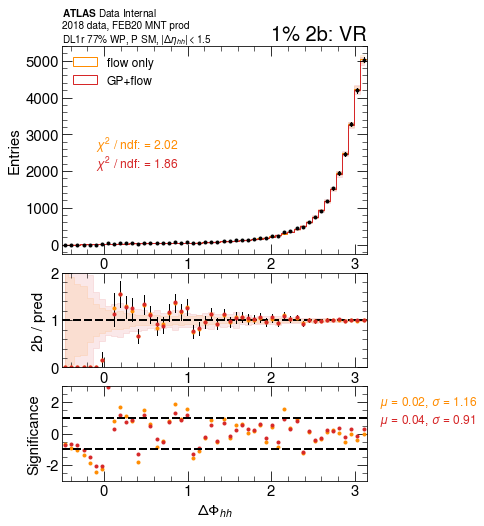

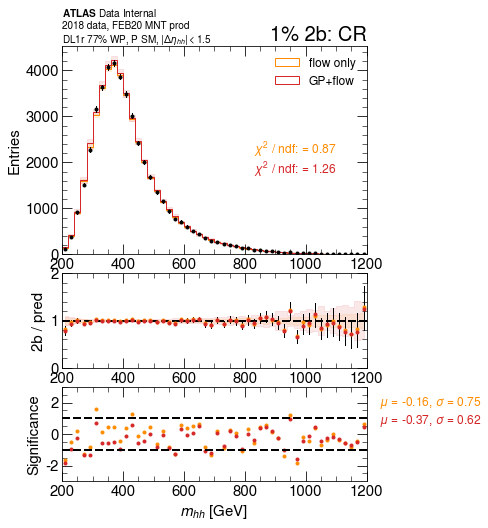

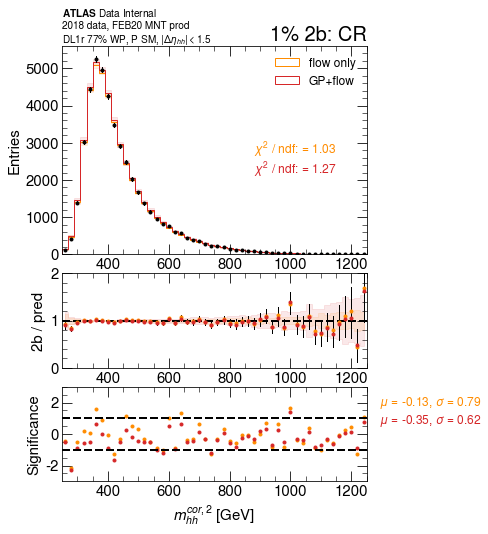

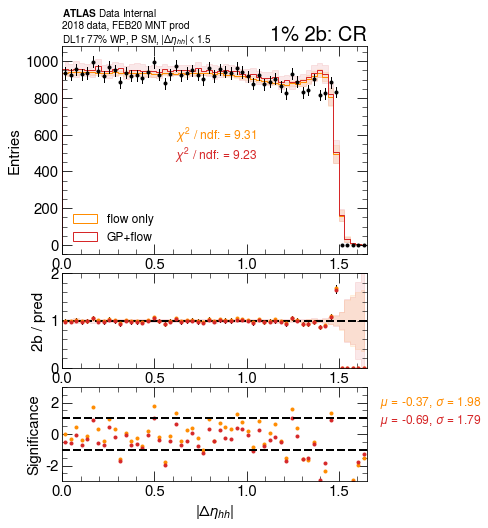

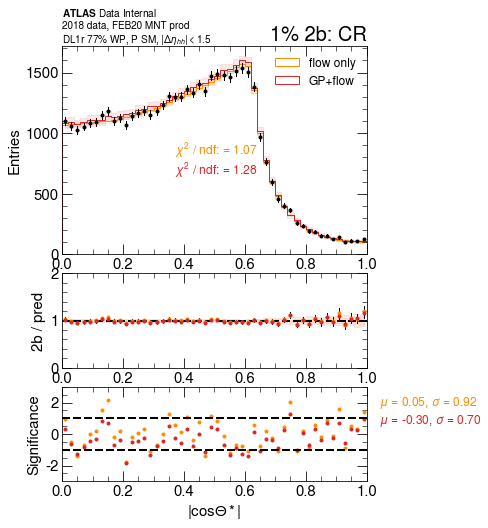

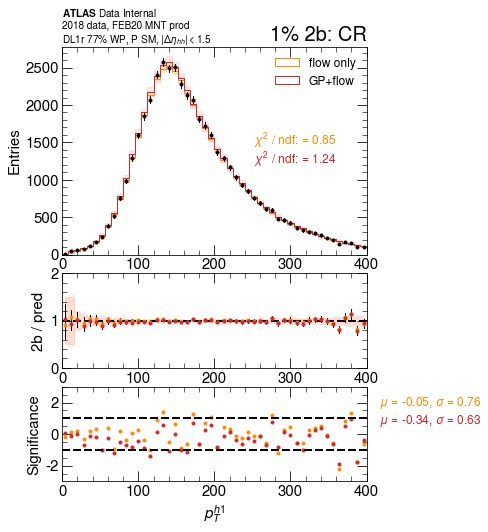

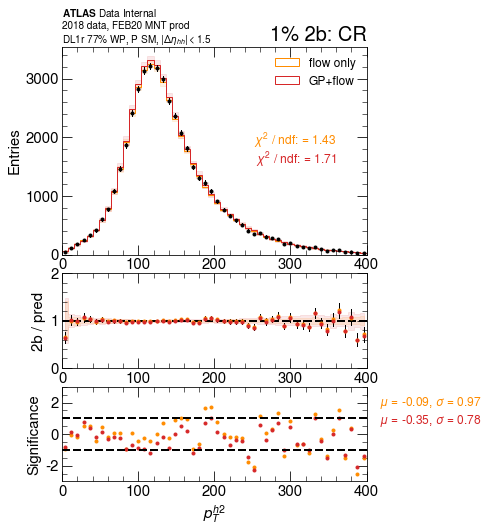

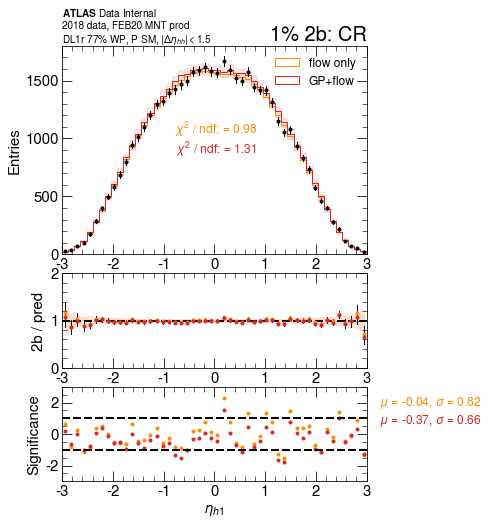

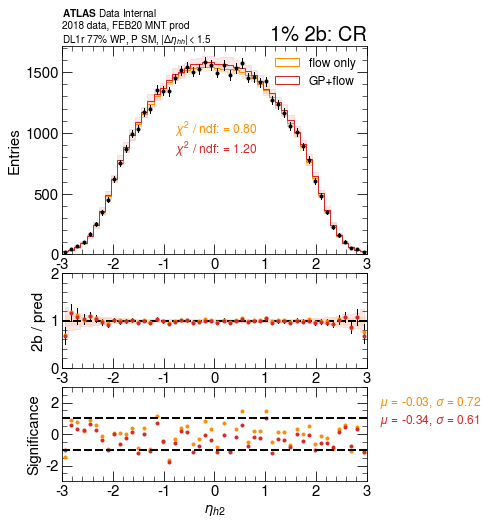

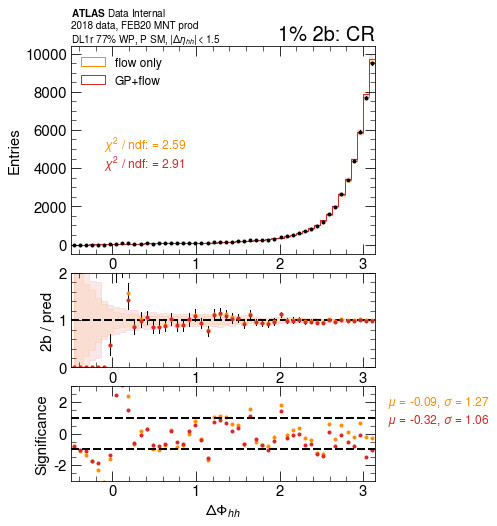

In [27]:
for i, region in enumerate(['SR','VR','CR']):
    
    mask = deta_cut & (d.df.kinematic_region==i)

    for k,fc in zip(configs,colors):

        if k != 'val2': continue
            
        for c,bi,r,xl,wx,wy,ha,va in zip(myVars,bis,myRanges,varLabels,
                                         [0.9, 0.9, 0.5, 0.5,0.9,0.9,0.5,0.5,0.1],
                                         [0.55,0.55,0.5,0.45,0.5,0.5,0.55,0.55,0.55],
                                         ['right','right','center','center','right','right','center','center','left'],
                                         ['top','top','bottom','bottom','bottom','bottom','bottom','bottom','top']):

            # Make the figure
            fig = plt.figure(figsize=(12,8))
            gs = gridspec.GridSpec(4,2)
            ax1 = fig.add_subplot(gs[:2,0])
            ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
            ax3 = fig.add_subplot(gs[3,0],sharex=ax1)

            n_2b,e = np.histogram(d.df.loc[mask,c],bi,r)
            xx = 0.5 * ( e[1:] + e[:-1] )

            # Add text for the chi^2s for these comparisons
            ls,lc = [], []
            zs,zc = [], []

            for his,color,l in zip([fdict[k],hdict[k]],['darkorange',fc],
                                   [f'flow only','GP+flow']):

                nom,std = his[f'{c}_{region}_mean'],his[f'{c}_{region}_std']

                ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
                ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)

                ax1.hist(xx, bi,r,color=color,histtype='step',weights=nom,label=l)
                ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,fmt='.',color=color,elinewidth=1,ecolor='k')

                X2 = chisquare(n_2b,nom)[0]
                ls.append(f'$\chi^2$ / ndf: = {X2/bi:.2f}')
                lc.append(color)

                z = significance(n_2b,nom,std)
                ax3.plot(xx,z,lw=0,marker='.',color=color)

                mu,sigma = np.mean(z),np.std(z)
                zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
                zc.append(color)
        
                if (k=='val1') and (i==0) and (c==myVars[0]):
                    print(l,np.sum(nom))

            # Add some curves and lines which only needs to be done once
            ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
            ax2.plot(r,[1]*2,'k--',lw=2)

            ax3.plot(r,[1]*2,'k--',lw=2)
            ax3.plot(r,[-1]*2,'k--',lw=2)

            # legends
            ax1.set_ylabel('Entries')
            ax2.set_ylabel('2b / pred')
            ax3.set_ylabel('Significance')
            ax3.set_xlabel(xl)

            # ranges
            ax1.set_xlim(r)
            ax2.set_ylim(0,2)
            ax3.set_ylim(-3, 3)
            ax1.legend(fontsize=12)

            ax1.set_title(f'1% 2b: {region}',loc='right',fontsize=20)
            ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes,fontsize=10)

            x = wx*r[1]+ (1-wx)*r[0]
            y = wy*ax1.get_ylim()[1]
            rainbow_text(x,y,ls,lc,yoffset=1,ax=ax1,fontsize=12,ha=ha,va=va)
            rainbow_text(1.03*r[1]+-.03*r[0],2.5,zs,zc,yoffset=1.1,ax=ax3,fontsize=12,ha='left',va='top')

            modelConfig = hdict[k]['modelConfig']
            if not os.path.exists(f'{figBaseDir}/{modelConfig}'):
                os.mkdir(f'{figBaseDir}/{modelConfig}')

            plt.savefig(f'{figBaseDir}/{modelConfig}/{c}_{region}.pdf',bbox_inches='tight')
            plt.show()
    #break

flow only 8070.468


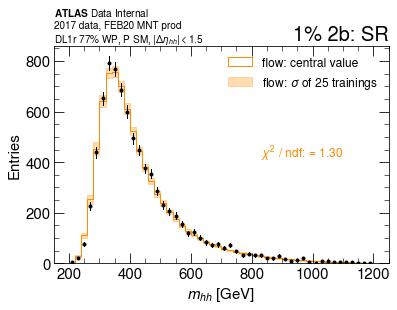

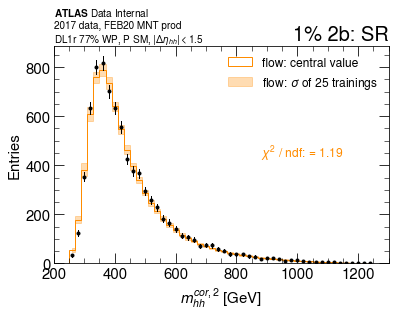

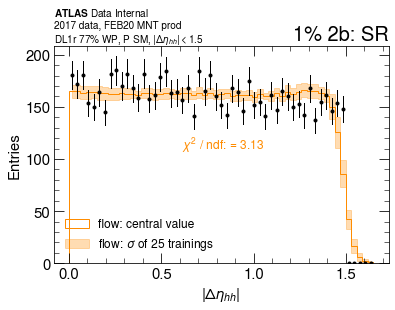

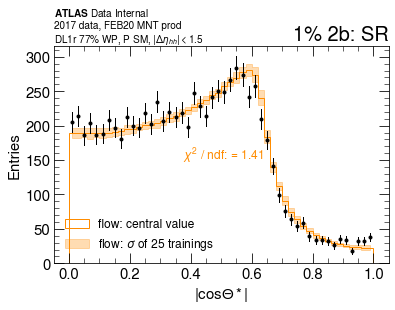

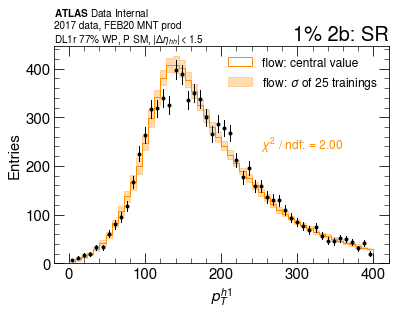

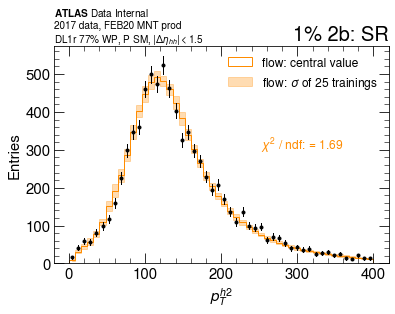

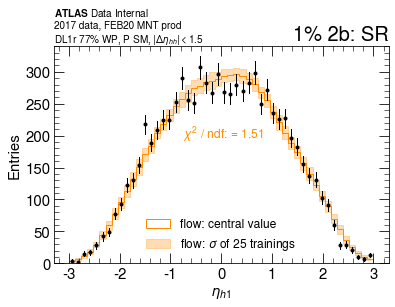

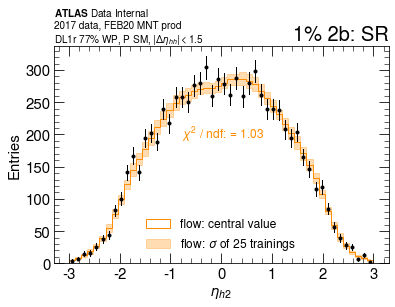

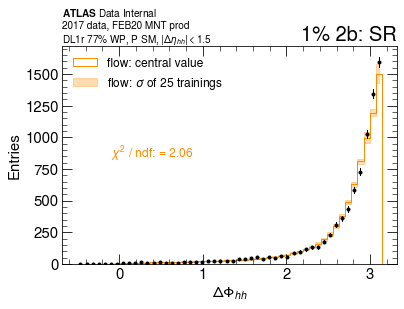

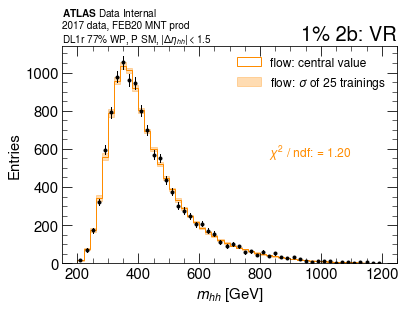

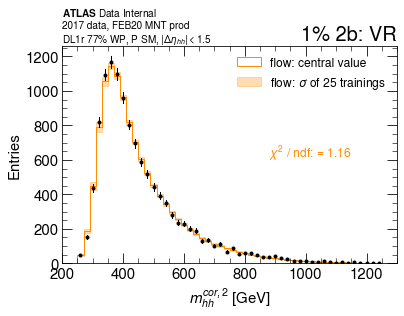

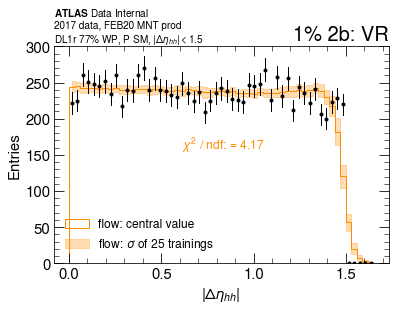

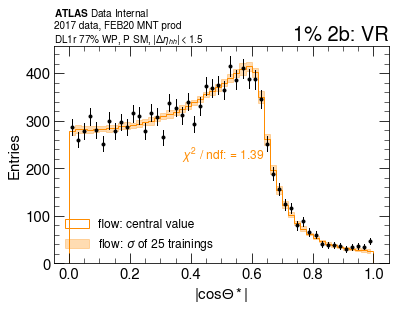

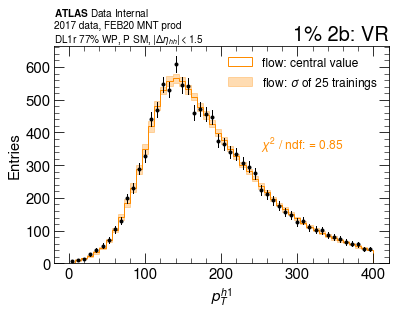

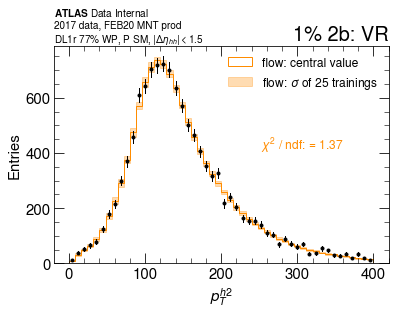

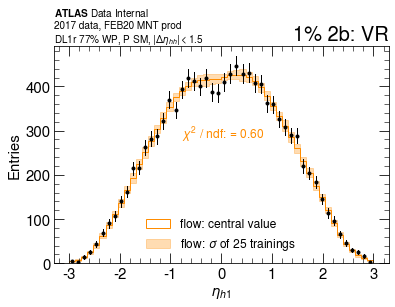

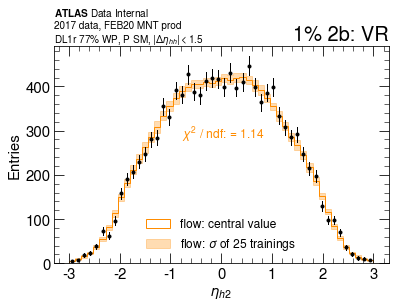

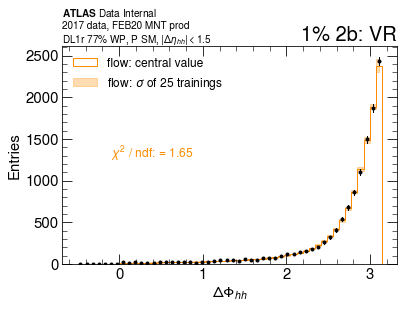

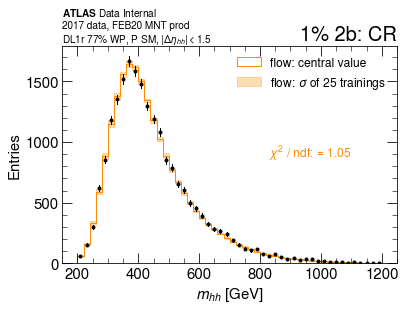

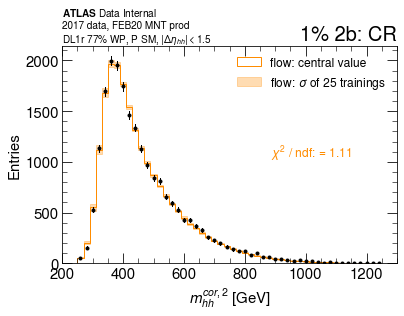

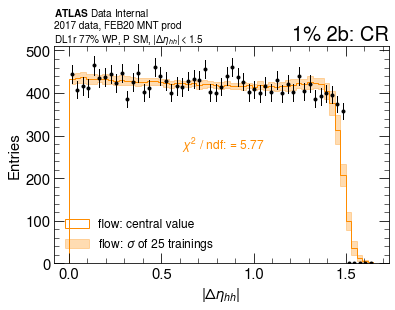

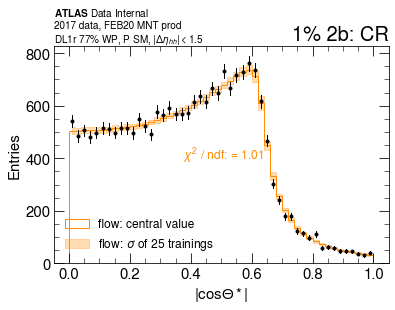

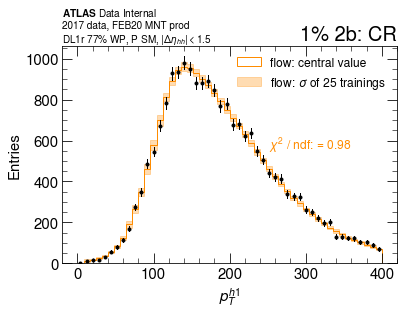

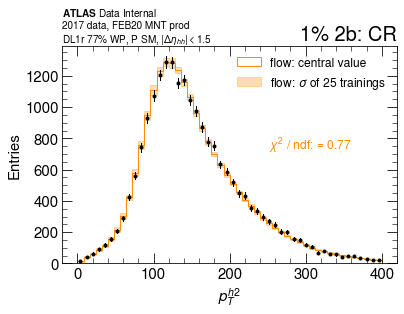

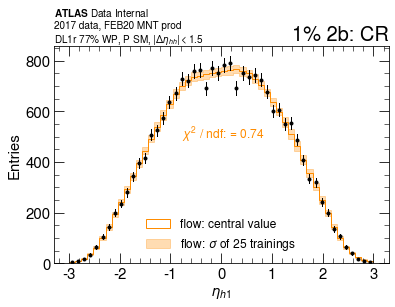

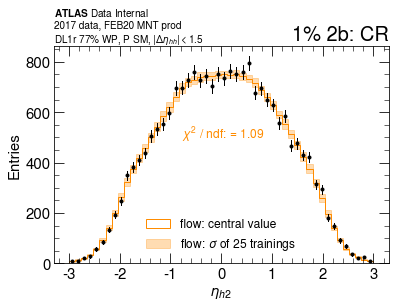

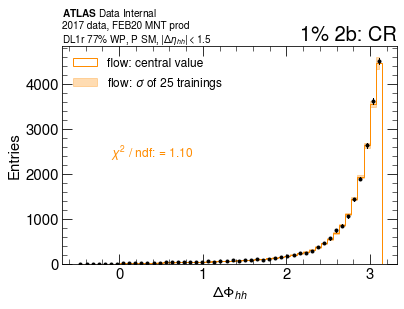

In [24]:
for i, region in enumerate(['SR','VR','CR']):
    
    mask = deta_cut & (d.df.kinematic_region==i)

    for k,fc in zip(configs,colors):

        if k != 'val1': continue

        for c,bi,r,xl,wx,wy,ha,va in zip(myVars,bis,myRanges,varLabels,
                                         [0.9, 0.9, 0.5, 0.5,0.9,0.9,0.5,0.5,0.1],
                                         [0.55,0.55,0.5,0.45,0.5,0.5,0.55,0.55,0.55],
                                         ['right','right','center','center','right','right','center','center','left'],
                                         ['top','top','bottom','bottom','bottom','bottom','bottom','bottom','top']):

            # Make the figure
            plt.figure()

            n_2b,e = np.histogram(d.df.loc[mask,c],bi,r)
            xx = 0.5 * ( e[1:] + e[:-1] )

            # Add text for the chi^2s for these comparisons
            ls,lc = [], []
            zs,zc = [], []

#             for his,color,l in zip([fdict[k],hdict[k]],['darkorange',fc],
#                                    [f'flow only','GP+flow']):
                
            his = fdict[k]
            color = 'darkorange'
            
            nom,std = his[f'{c}_{region}_mean'],his[f'{c}_{region}_std']

            plt.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.3,
                             label='flow: $\sigma$ of 25 trainings')

            plt.hist(xx, bi,r,color=color,histtype='step',weights=nom, label='flow: central value')

            X2 = chisquare(n_2b,nom)[0]
            ls.append(f'$\chi^2$ / ndf: = {X2/bi:.2f}')
            lc.append(color)

            if (k=='val1') and (i==0) and (c==myVars[0]):
                print(l,np.sum(nom))
                
                    
            # Add some curves and lines which only needs to be done once
            plt.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
            
            # legends
            plt.ylabel('Entries')
            plt.xlabel(xl)

            # ranges
            plt.legend(fontsize=12)

            ax1 = plt.gca()
            ax1.set_title(f'1% 2b: {region}',loc='right',fontsize=20)
            ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes,fontsize=10)

            x = wx*r[1]+ (1-wx)*r[0]
            y = wy*ax1.get_ylim()[1]
            rainbow_text(x,y,ls,lc,yoffset=1,ax=ax1,fontsize=12,ha=ha,va=va)
            
            modelConfig = hdict[k]['modelConfig']
            if not os.path.exists(f'{figBaseDir}/{modelConfig}_flowOnly'):
                os.mkdir(f'{figBaseDir}/{modelConfig}_flowOnly')

            plt.savefig(f'{figBaseDir}/{modelConfig}_flowOnly/{c}_{region}.pdf',bbox_inches='tight')
            
            plt.show()
    #break

OK - it's p clear rn that the norm is off, so I guess I could try ipso facto *norm* the # of events to 
1. The expected 2b SR yield
2. The expected 2b CR yield
3. The expected 2b VR yield

Alright - so the norm in the VR isn't off, and the prediction actually *overpredicts* the norm in the CR, so I don't think options (2) + (3) will be useful.

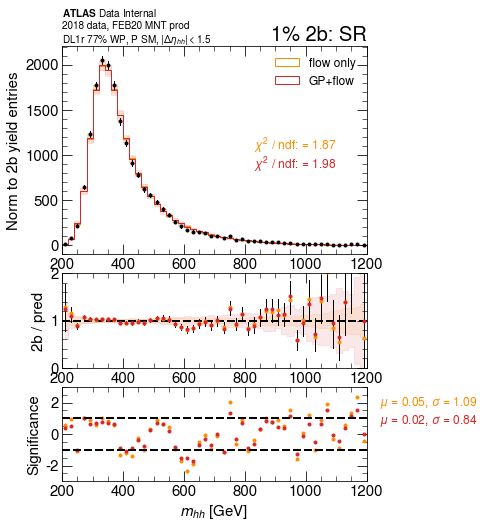

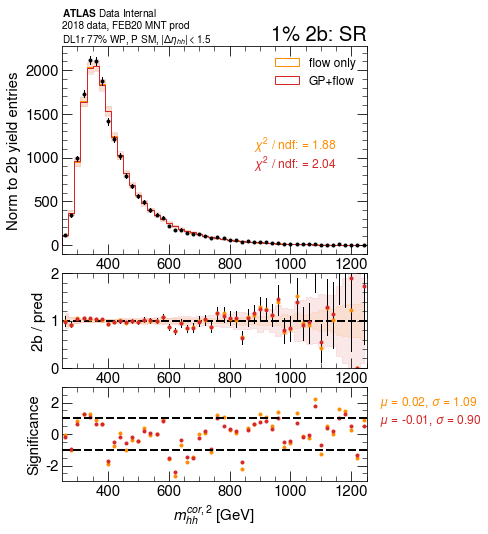

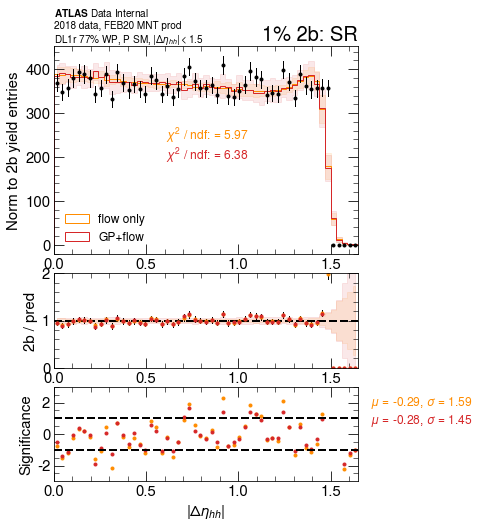

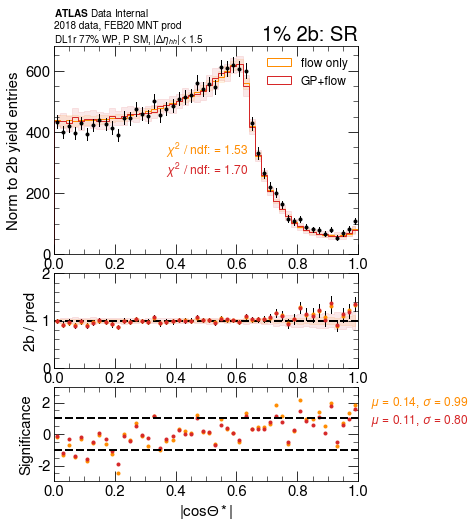

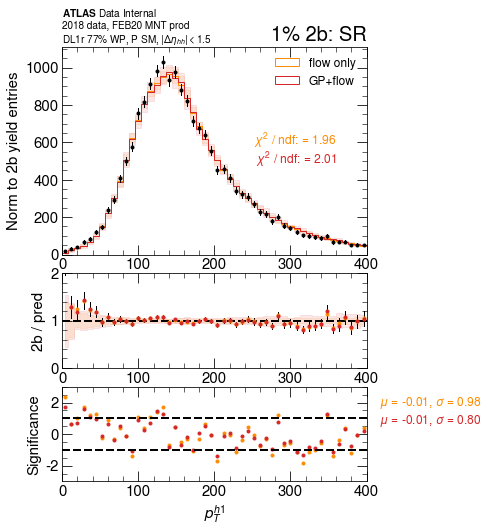

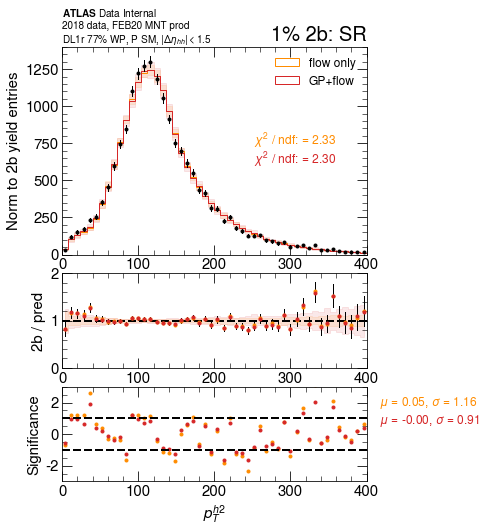

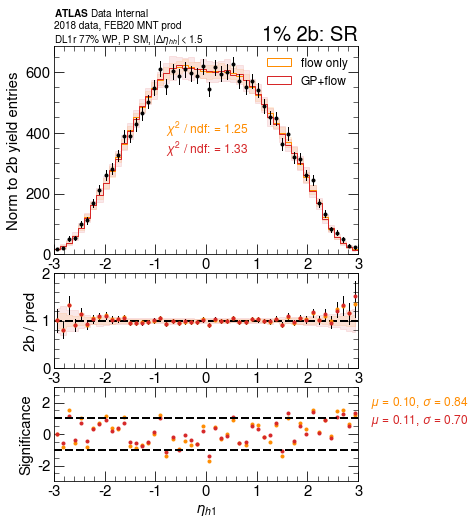

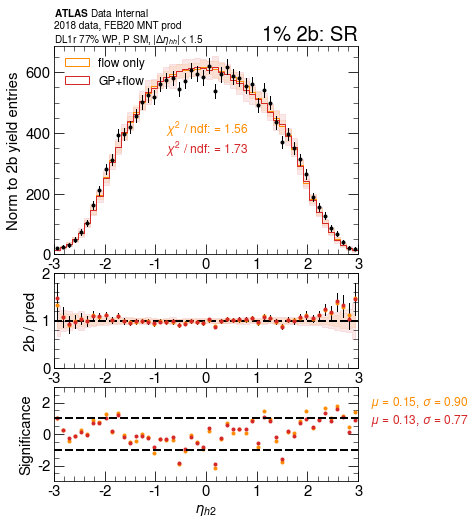

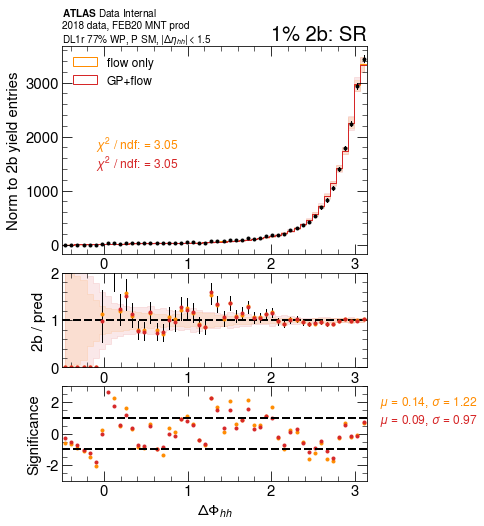

In [28]:
region = 'SR'
mask = deta_cut & (d.df.kinematic_region==0)

for k,fc in zip(configs,colors):

    if k != 'val2': continue

    for c,bi,r,xl,wx,wy,ha,va in zip(myVars,bis,myRanges,varLabels,
                                     [0.9, 0.9, 0.5, 0.5,0.9,0.9,0.5,0.5,0.1],
                                     [0.55,0.55,0.5,0.45,0.5,0.5,0.55,0.55,0.55],
                                     ['right','right','center','center','right','right','center','center','left'],
                                     ['top','top','bottom','bottom','bottom','bottom','bottom','bottom','top']):

        # Make the figure
        fig = plt.figure(figsize=(12,8))
        gs = gridspec.GridSpec(4,2)
        ax1 = fig.add_subplot(gs[:2,0])
        ax2 = fig.add_subplot(gs[2,0],sharex=ax1)
        ax3 = fig.add_subplot(gs[3,0],sharex=ax1)

        n_2b,e = np.histogram(d.df.loc[mask,c],bi,r)
        xx = 0.5 * ( e[1:] + e[:-1] )

        # Add text for the chi^2s for these comparisons
        ls,lc = [], []
        zs,zc = [], []

        for his,color,l in zip([fdict[k],hdict[k]],['darkorange',fc],
                               [f'flow only','GP+flow']):

            nom,std = his[f'{c}_{region}_mean'],his[f'{c}_{region}_std']

            if l=='GP+flow':
                f = np.sum(n_2b)/np.sum(nom)
                nom *= f
                std *= f
            
            ax1.fill_between(xx, nom+std, nom-std, color=color,zorder=0,step='mid',alpha=.1)
            ax2.fill_between(xx, (nom+std)/nom, (nom-std)/nom, color=color,zorder=0,step='mid',alpha=0.1)

            ax1.hist(xx, bi,r,color=color,histtype='step',weights=nom,label=l)
            ax2.errorbar(xx,n_2b/nom,np.sqrt(n_2b)/nom,fmt='.',color=color,elinewidth=1,ecolor='k')

            X2 = chisquare(n_2b,nom)[0]
            ls.append(f'$\chi^2$ / ndf: = {X2/bi:.2f}')
            lc.append(color)

            z = significance(n_2b,nom,std)
            ax3.plot(xx,z,lw=0,marker='.',color=color)

            mu,sigma = np.mean(z),np.std(z)
            zs.append(f'$\mu$ = {mu:1.2f}, $\sigma$ = {sigma:1.2f}')
            zc.append(color)

            if (k=='val1') and (i==0) and (c==myVars[0]):
                print(l,np.sum(nom))

        # Add some curves and lines which only needs to be done once
        ax1.errorbar(xx,n_2b,np.sqrt(n_2b),fmt='.',color='k',elinewidth=1)
        ax2.plot(r,[1]*2,'k--',lw=2)

        ax3.plot(r,[1]*2,'k--',lw=2)
        ax3.plot(r,[-1]*2,'k--',lw=2)

        # legends
        ax1.set_ylabel('Norm to 2b yield entries')
        ax2.set_ylabel('2b / pred')
        ax3.set_ylabel('Significance')
        ax3.set_xlabel(xl)

        # ranges
        ax1.set_xlim(r)
        ax2.set_ylim(0,2)
        ax3.set_ylim(-3, 3)
        ax1.legend(fontsize=12)

        ax1.set_title(f'1% 2b: {region}',loc='right',fontsize=20)
        ax1.text(0,1,text,ha='left',va='bottom',transform=ax1.transAxes,fontsize=10)

        x = wx*r[1]+ (1-wx)*r[0]
        y = wy*ax1.get_ylim()[1]
        rainbow_text(x,y,ls,lc,yoffset=1,ax=ax1,fontsize=12,ha=ha,va=va)
        rainbow_text(1.03*r[1]+-.03*r[0],2.5,zs,zc,yoffset=1.1,ax=ax3,fontsize=12,ha='left',va='top')

        modelConfig = hdict[k]['modelConfig']
        if not os.path.exists(f'{figBaseDir}/{modelConfig}'):
            os.mkdir(f'{figBaseDir}/{modelConfig}')

        plt.savefig(f'{figBaseDir}/{modelConfig}/{c}_{region}_norm.pdf',bbox_inches='tight')
        #break